In [1]:
import sys
sys.path.insert(0, 'F:/Workspace/idx2/build/Source/Python/RelWithDebInfo')
sys.path.insert(0, '/home/sci/duong/Desktop/idx2/build/Source/Python')
#sys.path.insert(0, 'F:/Workspace/idx2/build/Source/Python/Debug')
import idx2Py as i2p
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from ipywidgets import *
import concurrent.futures

%matplotlib notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

vmin = -10
vmax = 10

C:\Users\Duong\AppData\Local\Temp\ipykernel_3608\1588847095.py:14: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


## Set up color map

In [2]:
import colorsys

Points = [
  -10,
  -2.18552,
  -0.260014,
  0.00702716,
  0.372452,
  0.709768,
  10  
]

RGBPoints = [  
  [0.27843137254900002, 0.27843137254900002, 0.85882352941200002],
  [0.0, 0.33333333333333331, 1.0],
  [0.33333333333333331, 0.66666666666666663, 1.0],
  [0.0, 0.0, 0.49803921568627452],  
  [0.82745098039215681, 1.0, 0.73333333333333328],
  [1.0, 0.66666666666666663, 0.0],
  [0.87843137254899994, 0.30196078431399997, 0.30196078431399997]
]

def get_continuous_cmap(rgb_list, float_list=None):
  if float_list:
    # normalize the float list
    min_val = min(float_list)
    max_val = max(float_list)
    my_range = max_val - min_val
    float_list = [(v - min_val)/my_range for v in float_list]
    print(float_list)
  else:
    float_list = list(np.linspace(0, 1, len(rgb_list)))

  cdict = dict()  
  for num, col in enumerate(['red', 'green', 'blue']):
    col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(0, len(float_list))]
    cdict[col] = col_list
  cmp = matplotlib.colors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
  return cmp

my_cmap = get_continuous_cmap(RGBPoints, Points)

[0.0, 0.39072399999999996, 0.4869993, 0.500351358, 0.5186225999999999, 0.5354884, 1.0]


# Some helper functions

In [3]:
def get_file_name(input_dir, dataset, field, face, depth, time_from, time_to):
  return input_dir + '/' + dataset + '/' + field + '-face-' + repr(face) + '-depth-' + repr(depth) + '-time-' + repr(time_from) + '-' + repr(time_to) + '.idx2' 

def get_extent(dataset, face):
  if dataset == 'llc4320':
    if (face < 2):
      return (0, 0, 4320, 12960)
    elif (face > 2):
      return (0, 0, 12960, 4320)
    return (0, 0, 4320, 4320)
  elif dataset == 'llc2160':
    if (face < 2):
      return (0, 0, 2160, 6480)
    elif (face > 2):
      return (0, 0, 6480, 2160)
    return (0, 0, 2160, 2160)

# Query 
# extent should be a 4-tuple: (from_x, from_y, dim_x, dim_y)
def query_data(input_dir, dataset, times_per_file, times_per_brick, field, face, depth, time, downsampling, accuracy, extent=None):
  # determine the time step range to query from
  file_time_from    = (time // times_per_file) * times_per_file
  file_time_to      = file_time_from + times_per_file
  time_in_file      = time % times_per_file
  time_extent_from  = (time_in_file // times_per_brick) * times_per_brick
  
  # split the extent into 4 pieces
  if extent == None:
    extent = get_extent(dataset, face)
  e0 = extent
  e1 = (e0[0]           , e0[1]           , e0[2]//2   , e0[3]//2   )
  e2 = (e0[0]+(e0[2]//2), e0[1]           , e0[2]-e1[2], e0[3]//2   )
  e3 = (e0[0]           , e0[1]+(e0[3]//2), e0[2]//2   , e0[3]-e1[3])
  e4 = (e0[0]+(e0[2]//2), e0[1]+(e0[3]//2), e0[2]-e1[2], e0[3]-e1[3])
  e1 = (e1[0], e1[1], time_extent_from, e1[2], e1[3], times_per_brick)
  e2 = (e2[0], e2[1], time_extent_from, e2[2], e2[3], times_per_brick)
  e3 = (e3[0], e3[1], time_extent_from, e3[2], e3[3], times_per_brick)
  e4 = (e4[0], e4[1], time_extent_from, e4[2], e4[3], times_per_brick)

  file = get_file_name(input_dir, dataset, field, face, depth, file_time_from, file_time_to)
  print(file)
    
  array = None
  if extent[2] < 16 or extent[3] < 16: # if too small, don't spawn threads
    e = (extent[0], extent[1], time_extent_from, extent[2], extent[3], times_per_brick)
    array = i2p.DecodeExtent3f32(file, input_dir, extent, downsampling, accuracy)
  else:
    with concurrent.futures.ThreadPoolExecutor() as executor:
      f1 = executor.submit(i2p.DecodeExtent3f32, file, input_dir, e1, downsampling, accuracy)    
      f2 = executor.submit(i2p.DecodeExtent3f32, file, input_dir, e2, downsampling, accuracy)
      f3 = executor.submit(i2p.DecodeExtent3f32, file, input_dir, e3, downsampling, accuracy)
      f4 = executor.submit(i2p.DecodeExtent3f32, file, input_dir, e4, downsampling, accuracy)
      a1 = f1.result()
      a2 = f2.result()
      a3 = f3.result()
      a4 = f4.result()
      shape = (a1.shape[0], a1.shape[1] + a4.shape[1], a1.shape[2] + a4.shape[2])
      array = np.empty(shape)

      array[:, :a1.shape[1], :a1.shape[2]] = a1
      array[:, :a2.shape[1], a1.shape[2]:] = a2
      array[:, a1.shape[1]:, :a3.shape[2]] = a3
      array[:, a1.shape[1]:, a3.shape[2]:] = a4
  
  return array

# Visualize a single face through time for llc4320 (64 time steps)

J:/nasa/llc4320_64/llc4320/u-face-0-depth-0-time-0-64.idx2


<IPython.core.display.Javascript object>


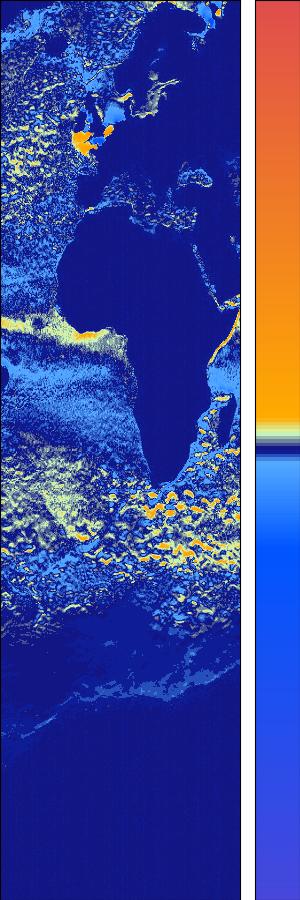

interactive(children=(IntSlider(value=0, description='t', layout=Layout(width='500px'), max=63), Output()), _d…

In [6]:
def test1():
  input_dir = 'J:/nasa/llc4320_64'
  dataset = 'llc4320'
  times_per_file = 64
  times_per_brick = 64
  face = 0
  depth = 0
  time = 0
  accuracy = 0.1
  downsampling = [4, 4, 1]

  plt.close()
   
  time_block = 0
  array = query_data(input_dir, dataset, times_per_file, times_per_brick, 'u', face, depth, time, downsampling, accuracy)

  fig = plt.figure(figsize = (3, 9))
  plot = plt.imshow(array[0, :, :], origin = 'lower', cmap = my_cmap, aspect = 'auto', vmin = vmin, vmax = vmax)
  plt.colorbar(plot)
  #plt.margins(0,0)
  plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
  first_draw = True

  def f(t):
    nonlocal time_block
    nonlocal array
    nonlocal first_draw

    curr_time_block = t // times_per_brick
    if curr_time_block != time_block:        
      array = query_data(input_dir, dataset, times_per_file, times_per_brick, 'u', face, depth, t, downsampling, accuracy)
      time_block = curr_time_block
    tt = min((t - time_block * times_per_brick) // pow(2, downsampling[2]), array.shape[0]-1)
    plot.set_data(array[tt,:,:])
    if first_draw:
      first_draw = False
      fig.canvas.draw_idle()

    plt.show()
    return

  interact(f, t = widgets.IntSlider(min=0, max=63, step=1, value=0, layout=Layout(width='500px')));

test1()

# Visualize a single face through time for llc2160 (1024 time steps)

J:/nasa/llc2160_1024/llc2160/u-face-0-depth-0-time-0-1024.idx2


<IPython.core.display.Javascript object>


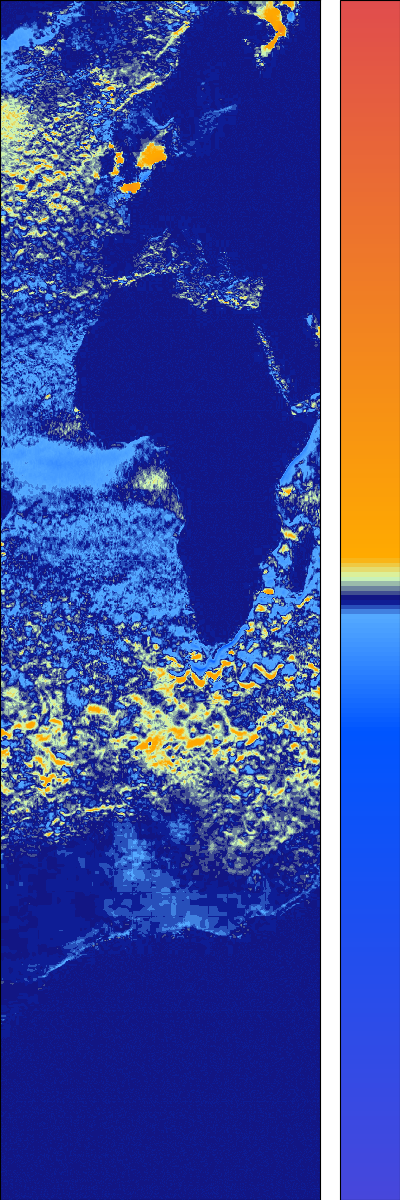

interactive(children=(IntSlider(value=0, description='t', layout=Layout(width='1100px'), max=1023), Output()),…

In [7]:
def test2():
  input_dir = 'J:/nasa/llc2160_1024'
  dataset = 'llc2160'
  times_per_file = 1024
  times_per_brick = 128
  face = 0
  depth = 0
  time = 0
  accuracy = 1
  downsampling = [2, 2, 1]

  plt.close()
  
  time_block = 0
  array = query_data(input_dir, dataset, times_per_file, times_per_brick, 'u', face, depth, time, downsampling, accuracy)

  fig = plt.figure(figsize = (4, 12))
  plot = plt.imshow(array[0, :, :], origin = 'lower', cmap = my_cmap, aspect = 'auto', vmin = vmin, vmax = vmax)
  plt.colorbar(plot)
  #plt.margins(0,0)
  plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
  first_draw = True

  def f(t):
    nonlocal time_block
    nonlocal array
    nonlocal first_draw

    curr_time_block = t // times_per_brick
    if curr_time_block != time_block:        
      array = query_data(input_dir, dataset, times_per_file, times_per_brick, 'u', face, depth, t, downsampling, accuracy)
      time_block = curr_time_block
    tt = min((t - time_block * times_per_brick) // pow(2, downsampling[2]), array.shape[0]-1)
    plot.set_data(array[tt,:,:])
    if first_draw:
      first_draw = False
      fig.canvas.draw_idle()

    plt.show()
    return

  interact(f, t = widgets.IntSlider(min=0, max=1023, step=1, value=0, layout=Layout(width='1100px')));

test2()

# Visualize four faces through time for llc4320 (64 time steps)

J:/nasa/llc4320_64/llc4320/u-face-0-depth-0-time-0-64.idx2
J:/nasa/llc4320_64/llc4320/u-face-1-depth-0-time-0-64.idx2
J:/nasa/llc4320_64/llc4320/v-face-3-depth-0-time-0-64.idx2
J:/nasa/llc4320_64/llc4320/v-face-4-depth-0-time-0-64.idx2


<IPython.core.display.Javascript object>


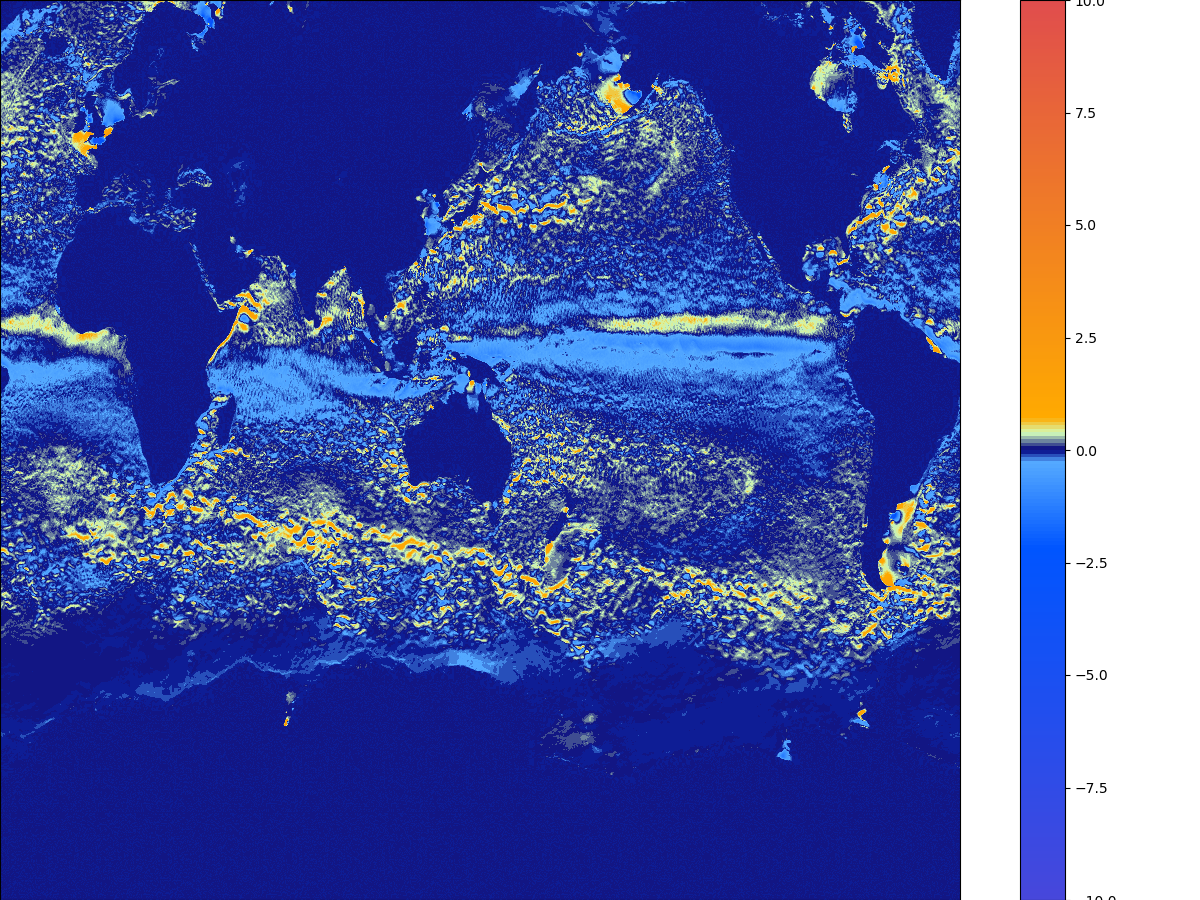

interactive(children=(IntSlider(value=0, description='t', layout=Layout(width='400px'), max=63), Output()), _d…

In [8]:
def test3():
  input_dir = 'J:/nasa/llc4320_64'
  dataset = 'llc4320'
  times_per_file = 64
  times_per_brick = 64
  face = 0
  depth = 0
  time = 0
  accuracy = 0.1
  downsampling = [3, 3, 1]

  plt.close()
  
  array = np.empty((1,1,1))

  with concurrent.futures.ThreadPoolExecutor() as executor:
      f0 = executor.submit(query_data, input_dir, dataset, times_per_file, times_per_brick, 'u', 0, depth, time, downsampling, accuracy)    
      f1 = executor.submit(query_data, input_dir, dataset, times_per_file, times_per_brick, 'u', 1, depth, time, downsampling, accuracy)
      f3 = executor.submit(query_data, input_dir, dataset, times_per_file, times_per_brick, 'v', 3, depth, time, downsampling, accuracy)
      f4 = executor.submit(query_data, input_dir, dataset, times_per_file, times_per_brick, 'v', 4, depth, time, downsampling, accuracy)
      a0 = f0.result()
      a1 = f1.result()
      a3 = f3.result()
      a4 = f4.result()    
      dx = a0.shape[2]
      dy = a0.shape[1]
      dt = a0.shape[0]  
      array = np.empty((dt, dy, dx*4))
      array[:, :, dx*0:dx*1] = a0[:, :, :]    
      array[:, :, dx*1:dx*2] = a1[:, :, :]
      for tt in range(0, dt):
        array[tt, :, dx*2:dx*3] = np.rot90(a3[tt, :, :])
        array[tt, :, dx*3:dx*4] = np.rot90(a4[tt, :, :])

  fig = plt.figure(figsize = (12, 9))
  plot = plt.imshow(array[0, :, :], origin = 'lower', cmap = my_cmap, aspect = 'auto', vmin = vmin, vmax = vmax)
  plt.colorbar(plot)
  plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
  first_draw = True

  time_block = 0
  def f(t): # get time step t   
    nonlocal time_block
    nonlocal array
    nonlocal first_draw

    curr_time_block = t // times_per_brick
    if curr_time_block != time_block:
      time_block = curr_time_block
    tt = min((t - time_block * times_per_brick) // pow(2, downsampling[2]), array.shape[0]-1)

    plot.set_data(array[tt, :,:])
    if first_draw:
      first_draw = False
      fig.canvas.draw_idle()

    plt.show() 

    return  

  interact(f, t = widgets.IntSlider(min = 0, max = 63, step = 1, value = 0, layout = Layout(width = '400px')));

test3()

# Animating four faces through time for llc4320 (64 time steps)

J:/nasa/llc4320_64/llc4320/u-face-0-depth-0-time-0-64.idx2
J:/nasa/llc4320_64/llc4320/u-face-1-depth-0-time-0-64.idx2
J:/nasa/llc4320_64/llc4320/v-face-3-depth-0-time-0-64.idx2
J:/nasa/llc4320_64/llc4320/v-face-4-depth-0-time-0-64.idx2


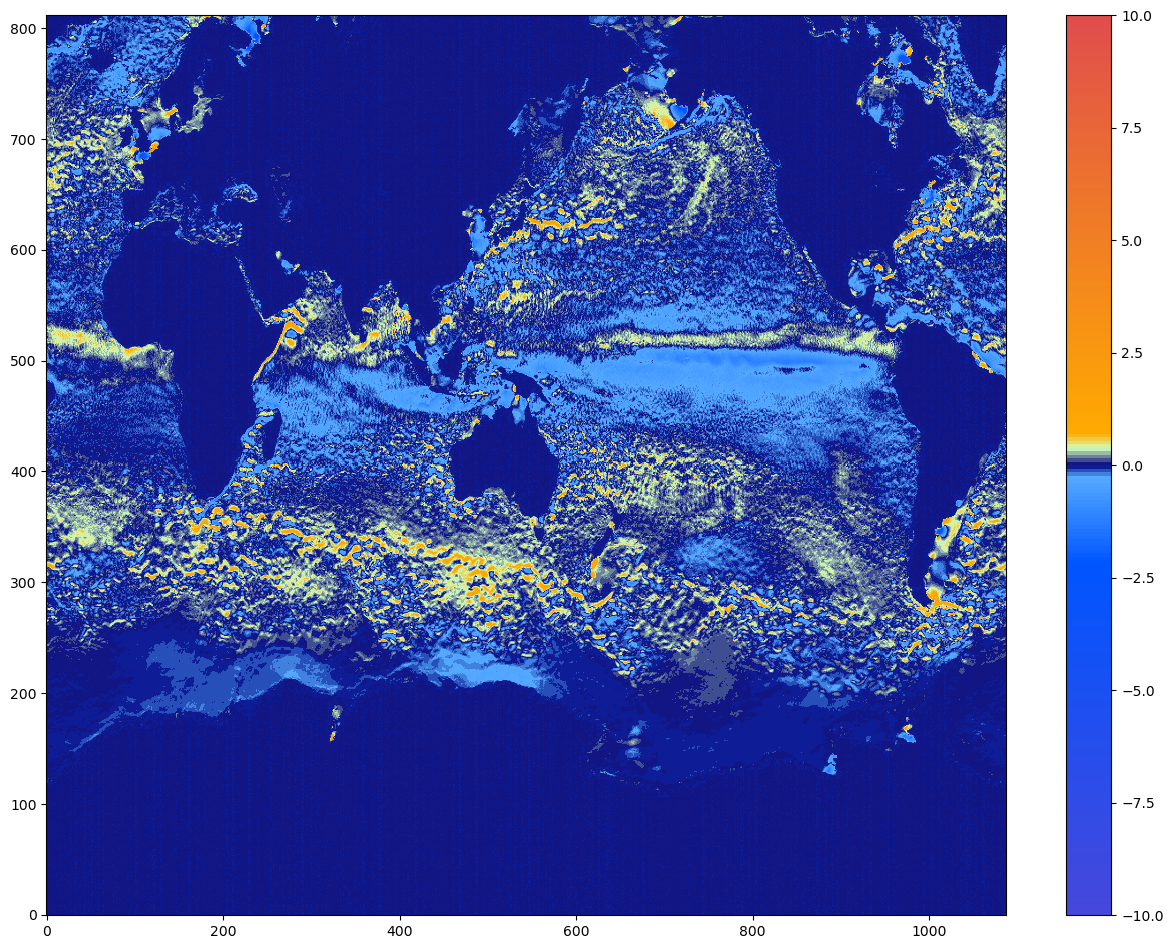

In [7]:

input_dir = 'J:/nasa/llc4320_64'
dataset = 'llc4320'
times_per_file = 64
times_per_brick = 64
face = 0
depth = 0
time = 0
accuracy = 0.1
downsampling = [4, 4, 1]

plt.close()

array = np.empty((1,1,1))

with concurrent.futures.ThreadPoolExecutor() as executor:
    f0 = executor.submit(query_data, input_dir, dataset, times_per_file, times_per_brick, 'u', 0, depth, time, downsampling, accuracy)    
    f1 = executor.submit(query_data, input_dir, dataset, times_per_file, times_per_brick, 'u', 1, depth, time, downsampling, accuracy)
    f3 = executor.submit(query_data, input_dir, dataset, times_per_file, times_per_brick, 'v', 3, depth, time, downsampling, accuracy)
    f4 = executor.submit(query_data, input_dir, dataset, times_per_file, times_per_brick, 'v', 4, depth, time, downsampling, accuracy)
    a0 = f0.result()
    a1 = f1.result()
    a3 = f3.result()
    a4 = f4.result()    
    dx = a0.shape[2]
    dy = a0.shape[1]
    dt = a0.shape[0]  
    array = np.empty((dt, dy, dx*4))
    array[:, :, dx*0:dx*1] = a0[:, :, :]    
    array[:, :, dx*1:dx*2] = a1[:, :, :]
    for tt in range(0, dt):
      array[tt, :, dx*2:dx*3] = np.rot90(a3[tt, :, :])
      array[tt, :, dx*3:dx*4] = np.rot90(a4[tt, :, :])

fig = plt.figure(figsize = (12, 9))
plot = plt.imshow(array[0, :, :], origin = 'lower', cmap = my_cmap, aspect = 'auto', vmin = vmin, vmax = vmax)
plt.colorbar(plot)
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
first_draw = True

def animate(frame_num):
  global first_draw, array
  plot.set_data(array[frame_num % 64, :,:])
  if first_draw:
    first_draw = False
    fig.canvas.draw_idle()
  return [plot]

#interact(f, t = widgets.IntSlider(min = 0, max = 63, step = 1, value = 0, layout = Layout(width = '400px')));
anim = FuncAnimation(fig, animate, frames=1000, interval=200, blit=True)
plt.show()


# Zoomed in visualization

J:/nasa/llc4320_64/llc4320/u-face-0-depth-0-time-0-64.idx2
J:/nasa/llc4320_64/llc4320/u-face-1-depth-0-time-0-64.idx2
J:/nasa/llc4320_64/llc4320/v-face-3-depth-0-time-0-64.idx2
J:/nasa/llc4320_64/llc4320/v-face-4-depth-0-time-0-64.idx2
J:/nasa/llc4320_64/llc4320/u-face-0-depth-0-time-0-64.idx2


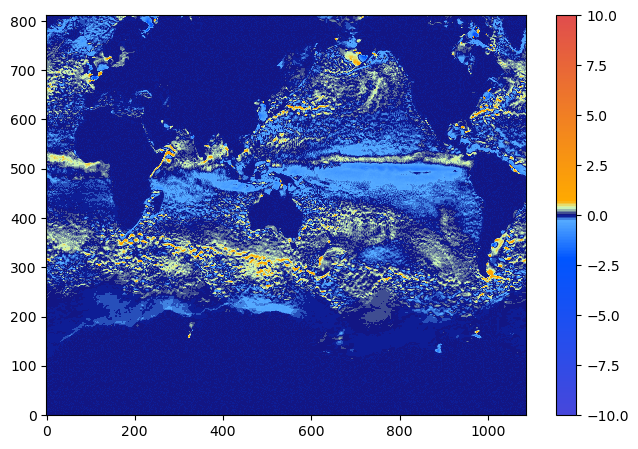

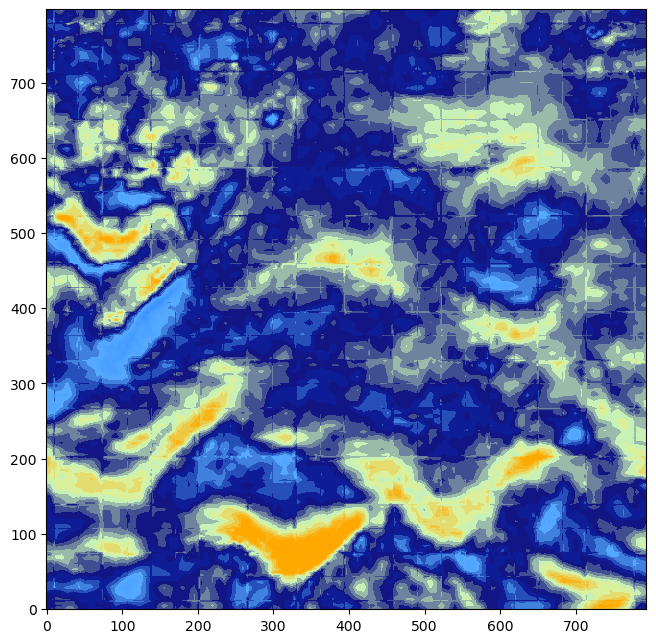

interactive(children=(IntSlider(value=100, description='x', layout=Layout(width='1000px'), max=1000, step=10),…

interactive(children=(IntSlider(value=300, description='y', layout=Layout(width='1000px'), max=700, step=10), …

interactive(children=(IntSlider(value=0, description='t', layout=Layout(width='500px'), max=63), Output()), _d…

In [9]:
def test5(): 
  input_dir = 'J:/nasa/llc4320_64'
  dataset = 'llc4320'
  times_per_file = 64
  times_per_brick = 64
  face = 0
  depth = 0
  time = 0
  accuracy = 1
  accuracy2 = 1
  downsampling = [4, 4, 2]
  downsampling2 = [0, 0, 0]
  array = np.empty((1,1,1))
  array2 = np.empty((1,1,1))
  
  xbegin = 100
  ybegin = 300
  xdim   = 50
  ydim   = 50

  plt.close()
  
  with concurrent.futures.ThreadPoolExecutor() as executor:
      f0 = executor.submit(query_data, input_dir, dataset, times_per_file, times_per_brick, 'u', 0, depth, time, downsampling, accuracy)    
      f1 = executor.submit(query_data, input_dir, dataset, times_per_file, times_per_brick, 'u', 1, depth, time, downsampling, accuracy)
      f3 = executor.submit(query_data, input_dir, dataset, times_per_file, times_per_brick, 'v', 3, depth, time, downsampling, accuracy)
      f4 = executor.submit(query_data, input_dir, dataset, times_per_file, times_per_brick, 'v', 4, depth, time, downsampling, accuracy)
      a0 = f0.result()
      a1 = f1.result()
      a3 = f3.result()
      a4 = f4.result()    
      dx = a0.shape[2]
      dy = a0.shape[1]
      dt = a0.shape[0]  
      array = np.empty((dt, dy, dx*4))
      array[:, :, dx*0:dx*1] = a0[:, :, :]    
      array[:, :, dx*1:dx*2] = a1[:, :, :]
      for tt in range(0, dt):
        array[tt, :, dx*2:dx*3] = np.rot90(a3[tt, :, :])
        array[tt, :, dx*3:dx*4] = np.rot90(a4[tt, :, :])
      #print(array.shape)

  px = 1/plt.rcParams['figure.dpi']  # pixel in inches
  fig, ax = plt.subplots()
  fig.set_size_inches(6, 4)
  #plot = axs[0].imshow(array[0, :, :], origin = 'lower', cmap = my_cmap, aspect = 'auto', vmin = vmin, vmax = vmax)
  #plt.colorbar(plot)
  #plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
  
  #fig = plt.figure(figsize = (6, 4))
  plot = plt.imshow(array[0, :, :], origin = 'lower', cmap = my_cmap, aspect = 'auto', vmin = vmin, vmax = vmax)
  plt.colorbar(plot)
  plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
  fig2, ax2 = plt.subplots()
  fig2.set_size_inches(6, 6)
  
  def query_region():
    nonlocal array, array2, xbegin, ybegin, face, depth
    d = (array.shape[2], array.shape[1])
    D = (4320 * 4, 4320 * 3)
    s = (D[0] / d[0], D[1] / d[1])
    extent = (int(xbegin*s[0]), int(ybegin*s[1]), int(xdim*s[0]), int(ydim*s[1]))
    #print(extent)

    # query the data for the ROI
    futures = []
    with concurrent.futures.ThreadPoolExecutor() as executor:
      min_face = 4
      max_face = 0
      m = max(extent[0], 0)
      M = min(extent[0] + extent[2], 4320)
      a = [np.empty((1,1,1)), np.empty((1,1,1)), np.empty((1,1,1)), np.empty((1,1,1))]
      if m < M: # intersect with face 1
        min_face = min(min_face, 0)
        max_face = max(max_face, 0)
        f0_extent = (m, extent[1], M - m, extent[3])      
        futures.append(executor.submit(query_data, input_dir, dataset, times_per_file, times_per_brick, 'u', 0, depth, time, downsampling2, accuracy2, f0_extent))
      m = max(extent[0], 4320)
      M = min(extent[0] + extent[2], 4320 * 2)
      if m < M: # intersect with face 1
        min_face = min(min_face, 1)
        max_face = max(max_face, 1)
        f1_extent = (m - 4320, extent[1], M - m, extent[3])      
        futures.append(executor.submit(query_data, input_dir, dataset, times_per_file, times_per_brick, 'u', 1, depth, time, downsampling2, accuracy2, f1_extent))
      m = max(extent[0], 4320 * 2)
      M = min(extent[0] + extent[2], 4320 * 3)
      if m < M: # intersect with face 3
        min_face = min(min_face, 2)
        max_face = max(max_face, 2)
        f3_extent = (m - 4320 * 2, extent[1], M - m, extent[3])
        futures.append(executor.submit(query_data, input_dir, dataset, times_per_file, times_per_brick, 'v', 3, depth, time, downsampling2, accuracy2, f3_extent))
      m = max(extent[0], 4320 * 3)
      M = min(extent[0] + extent[2], 4320 * 4)
      if m < M: # intersect with face 4
        min_face = min(min_face, 3)
        max_face = max(max_face, 3)
        f4_extent = (m - 4320 * 3, extent[1], M - m, extent[3])
        futures.append(executor.submit(query_data, input_dir, dataset, times_per_file, times_per_brick, 'v', 4, depth, time, downsampling2, accuracy2, f4_extent))    
      for face in range(min_face, max_face + 1):
        f = face - min_face
        a[f] = futures[f].result()
      dx = a[min_face].shape[2]
      dy = a[min_face].shape[1]
      dt = a[min_face].shape[0]         
      if min_face >= 2:
        dx = a[min_face].shape[1]
        dy = a[min_face].shape[2]    
      b = [np.empty((dt, dy, dx)) for i in range(min_face, max_face+1)]    
      for face in range(min_face, max_face + 1):
        f = face - min_face
        if face < 2:
          b[f] = a[f]
        else:
          for tt in range(0, dt):
            b[f][tt, :, :] = np.rot90(a[f][tt, :, :])        
      array2 = np.concatenate(b, 2)
      #print(array2.shape)
  
  
  query_region()
  plot2 = ax2.imshow(array2[0, :, :], origin = 'lower', cmap = my_cmap, aspect = 'auto', vmin = vmin, vmax = vmax)
  plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
  
  first_draw = True
  first_draw2 = True
  time_block = 0

  current_time = 0

  def f(t): # get time step t   
    nonlocal time_block, array, first_draw
    current_time = t
    curr_time_block = t // times_per_brick
    if curr_time_block != time_block:        
      time_block = curr_time_block
    tt = min((t - time_block * times_per_brick) // pow(2, downsampling[2]), array.shape[0]-1)
    plot.set_data(array[tt, :,:])
    if first_draw:
      first_draw = False
      fig.canvas.draw_idle()
    plt.show()      
  
  def draw_region():
    nonlocal time_block, array, first_draw2
    plot2.set_data(array2[0, :,:])
    if first_draw2:
      first_draw2 = False
      fig2.canvas.draw_idle()
    plt.show()

  line1 = None
  line2 = None
  line3 = None
  line4 = None

  def draw_rectangle():
    nonlocal line1, line2, line3, line4
    if line1 is not None:
      line1.pop(0).remove()
    if line2 is not None:
      line2.pop(0).remove()
    if line3 is not None:
      line3.pop(0).remove()
    if line4 is not None:
      line4.pop(0).remove()
    line1 = ax.plot([xbegin, xbegin], [ybegin, ybegin+ydim], color = 'r')
    line2 = ax.plot([xbegin, xbegin+xdim], [ybegin, ybegin], color = 'r')
    line3 = ax.plot([xbegin+xdim, xbegin+xdim], [ybegin, ybegin+ydim], color = 'r')
    line4 = ax.plot([xbegin, xbegin+xdim], [ybegin+ydim, ybegin+ydim], color = 'r') 
  
  def move_box_x(x):  
    nonlocal xbegin
    xbegin = x
    draw_rectangle()
    query_region()
    draw_region()

  def move_box_y(y):
    nonlocal ybegin
    ybegin = y    
    draw_rectangle()
    query_region()
    draw_region()

  #interact(f, t = widgets.IntSlider(min = 0, max = 63, step = 1, value = 0, layout = Layout(width = '500px')));
  interact(move_box_x, x = widgets.IntSlider(min = 0, max = 1000, step = 10, value = xbegin, layout = Layout(width = '1000px')));
  interact(move_box_y, y = widgets.IntSlider(min = 0, max = 700, step = 10, value = ybegin, layout = Layout(width = '1000px')));
  interact(f, t = widgets.IntSlider(min = 0, max = 63, step = 1, value = 0, layout = Layout(width = '500px')));
  
test5()

# Visualize four faces through depths

In [9]:
%%time
%matplotlib inline

array0 = None
array1 = None
array3 = None
array4 = None

downsampling = [3, 3, 3]

def f(d): # get time step t
  with concurrent.futures.ThreadPoolExecutor() as executor:
    accuracy = 0.01
    future0 = executor.submit(i2p.Decode3f32, 'D:/Datasets/nasa/llc_2160_32/llc2160/u-face-0-depth-' + repr(d) + '-time-0-32.idx2', input_dir, downsampling, accuracy)    
    future1 = executor.submit(i2p.Decode3f32, 'D:/Datasets/nasa/llc_2160_32/llc2160/u-face-1-depth-' + repr(d) + '-time-0-32.idx2', input_dir, downsampling, accuracy)
    future3 = executor.submit(i2p.Decode3f32, 'D:/Datasets/nasa/llc_2160_32/llc2160/u-face-3-depth-' + repr(d) + '-time-0-32.idx2', input_dir, downsampling, accuracy)
    future4 = executor.submit(i2p.Decode3f32, 'D:/Datasets/nasa/llc_2160_32/llc2160/u-face-4-depth-' + repr(d) + '-time-0-32.idx2', input_dir, downsampling, accuracy)
    array0 = future0.result()
    array1 = future1.result()
    array3 = future3.result()
    array4 = future4.result()
    fig, ((ax0, ax1, ax3, ax4)) = plt.subplots(1, 4, figsize=([15, 12]))
    ax0.axis('off')
    ax1.axis('off')
    ax3.axis('off')
    ax4.axis('off')
    ax0.imshow(array0[0, :, :], origin = 'lower', cmap = my_cmap, aspect = 'auto', vmin = vmin, vmax = vmax)
    ax1.imshow(array1[0, :, :], origin = 'lower', cmap = my_cmap, aspect = 'auto', vmin = vmin, vmax = vmax)
    ax3.imshow(np.rot90(array3[0, :, :]), origin = 'lower', cmap = my_cmap, aspect = 'auto', vmin = vmin, vmax = vmax)
    ax4.imshow(np.rot90(array4[0, :, :]), origin = 'lower', cmap = my_cmap, aspect = 'auto', vmin = vmin, vmax = vmax) 
  return  

interact(f, d = widgets.IntSlider(min = 0, max = 89, step = 1, value = 0, layout = Layout(width = '800px')));

interactive(children=(IntSlider(value=0, description='d', layout=Layout(width='800px'), max=89), Output()), _d…

CPU times: total: 3.09 s
Wall time: 1.08 s


<function __main__.f(d)>

# Vertical slicing along y (constant x) at a particular time step

In [5]:
%%time
%matplotlib inline

downsampling = [2, 2, 2]

timestep = 0
ndepths = 90
n = 2160

def to_face(f):
  if (f >= 2):
    return f + 1;
  return f
    
def f(x):
  face = to_face(x // n)
  xx = x % n # local x coordinate within the face
  nx = 0
  ny = ndepths
  future_array = [None] * ndepths
  with concurrent.futures.ThreadPoolExecutor() as executor:
    for d in range(0, ndepths):  
      extent = (xx, 0, timestep, 1, n * 3, 1)    
      if (face > 2):
        extent = (0, xx, timestep, n * 3, 1, 1)
      #print(extent)
      #print('D:/Datasets/nasa/llc_2160_32/llc2160/u-face-' + repr(face) + '-depth-' + repr(d) + '-time-0-32.idx2')
      future_array[d] = executor.submit(i2p.DecodeExtent3f32, 'D:/Datasets/nasa/llc_2160_32/llc2160/u-face-' + repr(face) + '-depth-' + repr(d) + '-time-0-32.idx2', input_dir, extent, downsampling, accuracy)

  array = None # store the whole result
  for d in range(0, ndepths):
    # figure out the shape of the output array once (at depth 0)
    a = future_array[d].result()
    #if (face > 2):
      #a = np.rot90(a)
    if d == 0:
      #print(a.shape)
      if (face < 2):
        nx = a.shape[1]
      else:
        nx = a.shape[2]
      array = np.empty((ny, nx))
      
    if (face < 2):
      array[d, :] = a[0, :, 0]
    else:
      array[d, :] = a[0, 0, :]
    #array[d, :] = a[0, :, (xx * a.shape[2]) // n]

  fig = plt.plot(figsize = ([1024, 90]))
  plt.imshow(array, origin = 'lower', cmap = my_cmap, aspect = 'auto', vmin = vmin, vmax = vmax)
  plt.show()
  return

interact(f, x = widgets.IntSlider(min = 0, max = 8639, step = 10, value = 0, layout = Layout(width = '800px')));

interactive(children=(IntSlider(value=0, description='x', layout=Layout(width='800px'), max=8639, step=10), Ou…

CPU times: total: 172 ms
Wall time: 173 ms


<function __main__.f(x)>